# Real or Not? NLP with Disaster Tweets

_Predict which Tweets are about real disasters and which ones are not_

## Settings

In [23]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set()

import re
import string

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam

## Load data

In [6]:
# Get train and test datasets
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
print('Train data size:', df_train.shape)
print('Test data size:', df_test.shape)

Train data size: (7613, 5)
Test data size: (3263, 4)


In [54]:
# Check the train table
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Class distrubution

In [5]:
def plot_class_layout(df, col):
    """Plot the distribution of classes.  
       df: a pamdas DataFrame,
       col: name of column indicating class labels."""
    x = df[col].value_counts()
    plt.figure()
    sns.barplot(x.index, x)
    plt.gca().set_ylabel('Samples')
    plt.show()

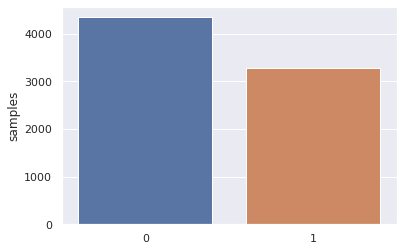

In [6]:
# Plot distribution of classes
plot_class_layout(df_train, 'target')

**There is no class imbalance issue in this classification problem.**

## EDA

### Number of characters

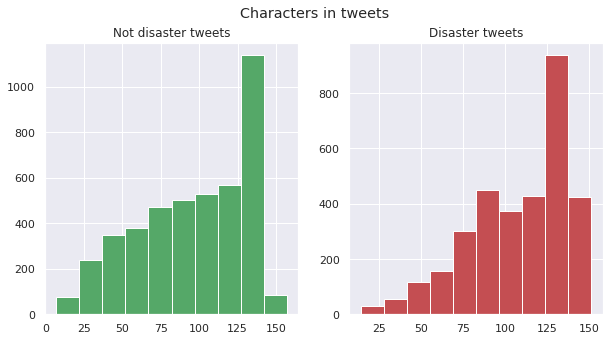

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
tweet_len = df_train[df_train['target']==0]['text'].str.len()
ax1.hist(tweet_len, color='g')
ax1.set_title('Not disaster tweets')
tweet_len = df_train[df_train['target']==1]['text'].str.len()
ax2.hist(tweet_len, color='r')
ax2.set_title('Disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

### Number of words

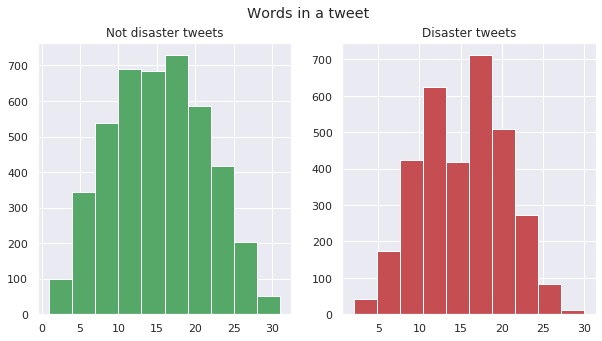

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
tweet_len = df_train[df_train['target']==0]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len, color='g')
ax1.set_title('Not disaster tweets')
tweet_len = df_train[df_train['target']==1]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len, color='r')
ax2.set_title('Disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

### Average word length in a tweet

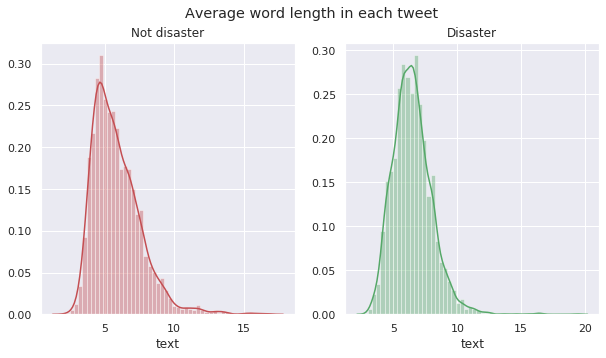

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
word = df_train[df_train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax1, color='r')
ax1.set_title('Not disaster')
word = df_train[df_train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax2, color='g')
ax2.set_title('Disaster')
fig.suptitle('Average word length in each tweet')
plt.show()

## Data cleaning

### Remove URL

In [7]:
def remove_url(text):
    """Remove URL in the text."""
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

In [8]:
# Remove URL
df_train['text'] = df_train['text'].apply(remove_url)
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Removing HTML tags

In [9]:
def remove_html(text):
    """Remove HTML tags in the text."""
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

In [10]:
# Remove HTML
df_train['text'] = df_train['text'].apply(remove_html)
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Romove emojis

In [11]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [12]:
# Remove emoji
df_train['text'] = df_train['text'].apply(remove_emoji)
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Remove punctuations

In [13]:
def remove_punctuation(text):
    """Remove punctuations in text."""
    # replacing the punctuations with no space, 
    # which in effect deletes the punctuation marks 
    table = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(table)

In [14]:
# Remove punctuation of tweets
df_train['text'] = df_train['text'].apply(remove_punctuation)
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All residents asked to shelter in place are be...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1


### Spelling Correction

In [28]:
from spellchecker import SpellChecker

def correct_spelling(text):
    """Correct spelling mistakes in the text."""
    corrected_text = []
    spell = SpellChecker()
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

### Stemming

In [15]:
# create an object of stemming function
SBStemmer = SnowballStemmer("english")

In [16]:
def stem_word(text):    
    """Stem each word based on word root in the given text."""
    text = [SBStemmer.stem(word) for word in text.split()]
    return " ".join(text) 

In [17]:
# Stem words in tweets
df_train['text'] = df_train['text'].apply(stem_word)
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deed are the reason of this earthquak may ...,1
1,4,NaN,NaN,forest fire near la rong sask canada,1
2,5,NaN,NaN,all resid ask to shelter in place are be notif...,1
3,6,NaN,NaN,13000 peopl receiv wildfir evacu order in cali...,1
4,7,NaN,NaN,just got sent this photo from rubi alaska as s...,1


### Remove stopwords

In [18]:
# extract the stopwords from nltk library
sw = stopwords.words('english')
# display the stopwords
np.array(sw)

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
       'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
       'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
       'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'm

In [19]:
def remove_stopword(text):
    """Remove stopwards in text."""
    # remove the stop words and lowercase the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

In [20]:
# Remove stopwords of tweets
df_train['text'] = df_train['text'].apply(remove_stopword)
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquak may allah forgiv us,1
1,4,NaN,NaN,forest fire near la rong sask canada,1
2,5,NaN,NaN,resid ask shelter place notifi offic evacu she...,1
3,6,NaN,NaN,13000 peopl receiv wildfir evacu order california,1
4,7,NaN,NaN,got sent photo rubi alaska smoke wildfir pour ...,1


### Vectorization

In [46]:
# Create vectorizer object for this binary problem
vectorizer = CountVectorizer(binary=True)
# Vectorize text
X_csr_matrix = vectorizer.fit_transform(df_train['text'])
# 'scipy.sparse.csr.csr_matrix' --> 'numpy.matrix'
X = X_csr_matrix#.toarray()
# Targets
y = df_train['target'].values
print('Type of X:', type(X))
print('Type of y:', type(y))

Type of X: <class 'scipy.sparse.csr.csr_matrix'>
Type of y: <class 'numpy.ndarray'>


#### Vectorization for GolVe

In [ ]:
def create_corpus(df):
    """Create corpus of the texts."""
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in sw))]
        corpus.append(words)
    return corpus

In [21]:
# Create corpus
corpus = create_corpus(df_train)

100%|██████████| 7613/7613 [00:01<00:00, 4006.37it/s]


In [22]:
embedding_dict = {}
with open('glove.6B.100d.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding_dict[word] = vectors
f.close()

In [26]:
MAX_LEN = 50
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)
tweet_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')

In [27]:
word_index = tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 13077


In [28]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 100))

for word, i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec = embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec

100%|██████████| 13077/13077 [00:00<00:00, 260676.36it/s]


## Train the model

### Logistic regression

In [50]:
# Train and test datasets
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=0)

# Train the model 
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
# Model prediction
y_pred = lr.predict(X_test)

# Performance f1 score
f1score = f1_score(y_test, y_pred)
print(f'Model (Logistic Regression) F1 Score: {f1score * 100:.2f}%')

Model (Logistic Regression) F1 Score: 75.42%


In [52]:
# Predict test tweets
X_test = vectorizer.transform(df_test['text']).toarray()
y_test_pred = lr.predict(X_test)

In [54]:
# Save submissin file
df_sub = pd.read_csv('sample_submission.csv')
df_sub['target'] = y_test_pred
df_sub.to_csv('submission.csv', index=False)
df_sub.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1


### GolVe

In [29]:
model = Sequential()

embedding = Embedding(num_words, 100, embeddings_initializer=Constant(embedding_matrix),
                      input_length=MAX_LEN, trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

optimzer = Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy', optimizer=optimzer, metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           1307800   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,350,105
Trainable params: 42,305
Non-trainable params: 1,307,800
_________________________________________________________________


In [32]:
train = tweet_pad[:df_train.shape[0]]
test = tweet_pad[df_train.shape[0]:]

In [33]:
X_train, X_test, y_train, y_test = \
    train_test_split(train, df_train['target'].values, test_size=0.15)
print('Shape of train', X_train.shape)
print("Shape of Validation ", X_test.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [34]:
history = model.fit(X_train, y_train, batch_size=4, epochs=15, 
                    validation_data=(X_test,y_test), verbose=2)

Train on 6471 samples, validate on 1142 samples
Epoch 1/15
6471/6471 - 71s - loss: 0.6917 - accuracy: 0.5667 - val_loss: 0.6895 - val_accuracy: 0.5788
Epoch 2/15
6471/6471 - 63s - loss: 0.6853 - accuracy: 0.5688 - val_loss: 0.6651 - val_accuracy: 0.5788
Epoch 3/15
6471/6471 - 61s - loss: 0.6181 - accuracy: 0.6704 - val_loss: 0.5585 - val_accuracy: 0.7382
Epoch 4/15
6471/6471 - 65s - loss: 0.5914 - accuracy: 0.7073 - val_loss: 0.5479 - val_accuracy: 0.7452
Epoch 5/15
6471/6471 - 60s - loss: 0.5852 - accuracy: 0.7147 - val_loss: 0.5479 - val_accuracy: 0.7443
Epoch 6/15
6471/6471 - 63s - loss: 0.5774 - accuracy: 0.7203 - val_loss: 0.5445 - val_accuracy: 0.7426
Epoch 7/15
6471/6471 - 61s - loss: 0.5710 - accuracy: 0.7282 - val_loss: 0.5444 - val_accuracy: 0.7426
Epoch 8/15
6471/6471 - 62s - loss: 0.5744 - accuracy: 0.7289 - val_loss: 0.5427 - val_accuracy: 0.7426
Epoch 9/15
6471/6471 - 68s - loss: 0.5683 - accuracy: 0.7330 - val_loss: 0.5430 - val_accuracy: 0.7417
Epoch 10/15
6471/6471 - 6

In [ ]:
sample_sub = pd.read_csv('sample_submission.csv')
y_pred = model.predict(test)
y_pred = np.round(y_pre).astype(int).reshape(3263)
sub = pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pred})
sub.to_csv('submission.csv', index=False)
sub.head()